<h3><center>1. Introduction to the Planet Dataset</center></h3>

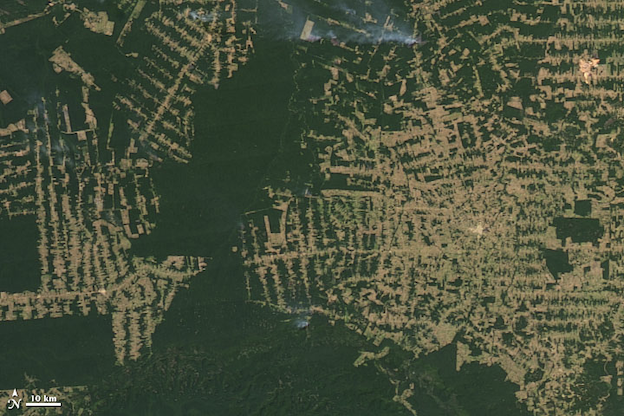

<div style="font-family:verdana; word-spacing:1.7px;">
The Planet: Understanding the Amazon from Space competition was held on Kaggle in 2017. The competition involved classifying small squares of satellite images taken from space of the Amazon rainforest in Brazil in terms of 17 classes, such as agriculture, clear, and water. <br><br>
The problem is an example of a multi-label image classification task, where one or more class labels must be predicted for each label. This is different from multiclass classification, where each image is assigned one from among many classes.
    </div>
    

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

from keras.preprocessing.image import img_to_array, load_img

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.layers import Dropout

from keras.optimizers import SGD

<h3><center>1. Explore Datasets</center></h3>

In [ ]:
folder = '../input/planets-dataset/planet/planet/train-jpg/'

plt.figure(figsize=(20,10))
for i in range(9):
  
    plt.subplot(330 + 1 + i)
  
    filename = folder + 'train_' + str(i) + '.jpg' 
    image = plt.imread(filename)
    
    plt.imshow(image)

plt.show()

In [ ]:
file = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
file.head(10)

<blockquote>Since it is a multilabel classification, we have to split the tags and have to identify the unique set of labels</blockquote>

<h3><center>2. Create Mappings</center></h3>

In [ ]:
def create_mapping(file):
    tags = set()
    for tag in tqdm(list(file['tags'].values)):
        split = tag.split(' ')
        tags.update(split)
    tags = list(tags)
    tags.sort()
    
    tags_mapping = dict()
    for idx, tag in enumerate(tags):
        tags_mapping[tag] = idx
    
    return tags_mapping

tags_mapping = create_mapping(file)
tags_mapping

<h3><center>3. Encode Tags</center></h3>

In [ ]:
# Encoding example 
file_name = 'train_4.jpg'
tags = file.query(f"image_name == '{file_name.split('.')[0]}'")['tags'].values[0].split(' ')
encoded = np.zeros(len(tags_mapping), dtype='uint8')
for tag in tags:
    encoded[tags_mapping[tag]] = 1

print(f'Tags : {tags}')
print(f'Encoded : {encoded}')

In [ ]:
def encode_tags(file_name, tags_mapping):
    encoded = np.zeros(len(tags_mapping), dtype='uint8')
    
    tags = file.query(f"image_name == '{file_name.split('.')[0]}'")['tags'].values[0].split(' ')
    for tag in tags:
        encoded[tags_mapping[tag]] = 1
    
    return encoded

<h3><center>4. Create In-Memory Variables</center></h3>

In [ ]:
TRAIN_PATH = '../input/planets-dataset/planet/planet/train-jpg/'
TEST_PATH = '../input/planets-dataset/test-jpg-additional/test-jpg-additional/'

def create_variables(tags_mapping):
    photos, targets = list(), list()
    
    for file_name in tqdm(os.listdir(TRAIN_PATH)[:35000]):
        photo = load_img(TRAIN_PATH + file_name , target_size = (128, 128))
        photo = img_to_array(photo, dtype='uint8')
        
        encoded = encode_tags(file_name, tags_mapping)
        
        photos.append(photo)
        targets.append(encoded)
    
    X = np.asarray(photos, dtype='uint8')
    y = np.asarray(targets)
    
    
    return X, y

In [ ]:
X, y = create_variables(tags_mapping)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
print(X.shape)
print(y.shape)

'''np.savez_compressed('planet_data.npz', X, y)'''

In [ ]:
del X, y
del file
gc.collect()

<h3><center>5. Load Dataset</center></h3>

In [ ]:
def load_dataset():
    data = np.load('/kaggle/input/output/planet_data.npz')
    
    X, y = data['arr_0'], data['arr_1']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_dataset()

<h3><center>6. Evaluate targets with 1 predictions</center></h3>
<div style="font-family:verdana; word-spacing:1.9px;">
The Fbeta-measure is a generalization of the F-measure that adds a configuration parameter called beta. A default beta value is 1.0, which is the same as the F-measure. A smaller beta value, such as 0.5, gives more weight to precision and less to recall, whereas a larger beta value, such as 2.0, gives less weight to precision and more weight to recall in the calculation of the score.
    </div>

In [ ]:
train_yhat = np.asarray([np.ones(y_train.shape[1]) for _ in range(y_train.shape[0])])
test_yhat = np.asarray([np.ones(y_test.shape[1]) for _ in range(y_test.shape[0])])

train_score = fbeta_score(y_train, train_yhat, 2, average='samples') 
test_score = fbeta_score(y_test, test_yhat, 2, average='samples')
print('All Ones: train=%.3f, test=%.3f' % (train_score, test_score))

<div style="font-family:verdana; word-spacing:1.7px;">
The all-one predictions are prepared and then evaluated and the scores are reported. We can see that an all ones prediction for both datasets results in a score of about 0.48.
    </div>

<h3><center>7. F-beta Measure</center></h3>

In [ ]:
from keras import backend

def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)
    
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

<h3><center>8. Base-Line Model, VGG-3 blocks</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    # Block 1
    model.add(Conv2D(32, (3,3), input_shape=(128,128,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    
    #Block 2
    model.add(Conv2D(64, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    
    #Block 3
    model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(128, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(17, activation='sigmoid'))
    
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    
    return model

In [ ]:
def summarize_diagnostics(history):
    plt.figure(figsize=(10,5))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train') 
    plt.plot(history.history['val_loss'], color='orange', label='test')

        # plot accuracy
    plt.subplot(212)
    plt.title('F-beta Score') 
    plt.plot(history.history['fbeta'], color='blue', label='train') 
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    plt.show()

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow(X_train, y_train, batch_size=128)
test_it = datagen.flow(X_test, y_test, batch_size=128)

model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                             validation_data=test_it, validation_steps=len(test_it), 
                              epochs=20, callbacks=[rlrop], verbose=1)

[](http://)FBETA Score - 82.65 

In [ ]:
summarize_diagnostics(history)

In [ ]:
del history
del model
gc.collect()

In [ ]:
del datagen
del train_it
del test_it
gc.collect()

<h3><center>9. Model Improvement - VGG + Dropout</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    # Block 1
    model.add(Conv2D(32, (3,3), input_shape=(128,128,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    
    #Block 2
    model.add(Conv2D(64, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    #Block 3
    model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(128, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    
    return model

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow(X_train, y_train, batch_size=128)
test_it = datagen.flow(X_test, y_test, batch_size=128)

model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                             validation_data=test_it, validation_steps=len(test_it), 
                              epochs=20, callbacks=[rlrop], verbose=1)

FBETA Score - 81.41

In [ ]:
loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

In [ ]:
del history
del model
gc.collect()

<h3><center>10. Improvement of Model - VGG + Augmentation</center></h3>

In [ ]:
def define_model():
    model = Sequential()
    # Block 1
    model.add(Conv2D(32, (3,3), input_shape=(128,128,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(32, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    
    #Block 2
    model.add(Conv2D(64, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    
    #Block 3
    model.add(Conv2D(128, (3,3), input_shape=(128,128,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(Conv2D(128, (3,3), activation='relu',
                    padding='same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(17, activation='sigmoid'))
    
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])
    
    return model

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, 
                             rotation_range=90)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = train_datagen.flow(X_train, y_train, batch_size=128)
test_it = test_datagen.flow(X_test, y_test, batch_size=128)

model = define_model()

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              min_delta=1E-7)

history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
                             validation_data=test_it, validation_steps=len(test_it), 
                              epochs=40, verbose=1)

In [ ]:
loss, fbeta = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

In [ ]:
'''filename = 'model_vgg.h5'
model.save(filename)'''

'''model = np.load('/kaggle/input/output/model_vgg.h5')'''

In [ ]:
summarize_diagnostics(history)

We can make the model learn more by increasing the epochs to 70

In [ ]:
del history
gc.collect()

<h3><center>11. Predict Image</center></h3>

In [ ]:
# create a mapping of tags to integers given the loaded mapping file
def create_tag_mapping(mapping_csv):
	# create a set of all known tags
	labels = set()
	for i in range(len(mapping_csv)):
		# convert spaced separated tags into an array of tags
		tags = mapping_csv['tags'][i].split(' ')
		# add tags to the set of known labels
		labels.update(tags)
	# convert set of labels to a list to list
	labels = list(labels)
	# order set alphabetically
	labels.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {labels[i]:i for i in range(len(labels))}
	inv_labels_map = {i:labels[i] for i in range(len(labels))}
	return labels_map, inv_labels_map

# convert a prediction to tags
def prediction_to_tags(inv_mapping, prediction):
	# round probabilities to {0, 1}
	values = prediction.round()
	print(values)
	# collect all predicted tags
	tags = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
	return tags

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(128, 128))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 128, 128, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

# load an image and predict the class
def run_example(inv_mapping, model, file_name):
	# load the image
	img = load_image(TRAIN_PATH + file_name)	
	# predict the class
	result = model.predict(img)
	#print(result[0])
	# map prediction to tags
	tags = prediction_to_tags(inv_mapping, result[0])
	print('Predicted : ', tags)

In [ ]:
filename = '../input/planets-dataset/planet/planet/train_classes.csv'
mapping_csv = pd.read_csv(filename)
mapping_csv.head()

In [ ]:
create_tag_mapping(mapping_csv)

Example 1. 

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_100.jpg')
    
plt.imshow(image)

In [ ]:
# create a mapping of tags to integers
_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_100.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_100"')['tags'].values)

Example 2.

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_10.jpg')
    
plt.imshow(image)

In [ ]:
_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_10.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_10"')['tags'].values)

Example 3.

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_10010.jpg')
    
plt.imshow(image)

In [ ]:
_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_10010.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_10010"')['tags'].values)

Example 4.

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_10016.jpg')
    
plt.imshow(image)

In [ ]:
_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_10016.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_10016"')['tags'].values)

Example 5.

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_10026.jpg')
    
plt.imshow(image)

_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_10026.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_10026"')['tags'].values)

Example 6.

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_40475.jpg')
    
plt.imshow(image)

_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_40475.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_40475"')['tags'].values)

In [ ]:
image = plt.imread(TRAIN_PATH + 'train_40478.jpg')
    
plt.imshow(image)

_, inv_mapping = create_tag_mapping(mapping_csv)
# entry point, run the example
run_example(inv_mapping , model, 'train_40478.jpg')
print('Expected : ', mapping_csv.query('image_name == "train_40478"')['tags'].values)